# Color Detection with KNN and DBSCAN

This notebook is about color detction of an image. Color detction service is needed in computer vision to identify the color of an object like shirt, car, bus, bottle etc. We can slpit the object from the image and detect the color through various algorithm.

### Import packages

In [1]:
import os
import re
import json
import pandas as pd
import numpy as np
from collections import Counter

from matplotlib import pyplot as plt
from sklearn.cluster import DBSCAN, KMeans
from sklearn.neighbors import NearestNeighbors
import cv2

In [2]:
def show_image(img):
    """
        This method is used to visualize image.
        :param img: A numpy array.
    """
    plt.imshow(img)
    # plt.savefig('./tested_images/test.png')
    plt.show()

def load_dataset(file_name):
    """
        This method used to load the json file.
    @param file_name: A json file name
    """
    with open(file_name, 'r') as j:
        color_codes = json.load(j)
    return color_codes

def rgb2hex(rgb):
    """ This method is used to convert RGB value to HEX """
    return "#{:02x}{:02x}{:02x}".format(int(rgb[0]), int(rgb[1]), int(rgb[2]))

def get_labels(rgbs, color_codes):
    """
        This method is used to label the RGB color codes.
    :param rgbs: contains the rgb values which will be labeled.
    :param color_codes: A dictionary contains the RGB color codes and corresponding color name.
    :return: A list contains the name of the colors
    """
    Y = np.array(color_codes['names'])

    neigh = NearestNeighbors(n_neighbors=1, radius=10) # Nearest Neighbour with n=1
    neigh.fit(color_codes['rgbs'])

    X = rgbs
    index = neigh.kneighbors(X, 1, return_distance=False) # get the most nearest neighbours label

    return Y[index] # get and return the color label

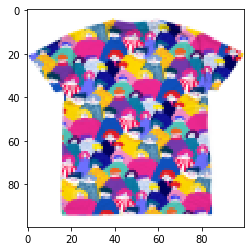

In [4]:
color_code_file = 'datasets/color_name_hex_rgb_codes.json'

# Read the Image
image_path = 'images/test32.png'
image = cv2.imread(image_path)
image = cv2.resize(image, (100, 100), interpolation = cv2.INTER_AREA)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # Convert the image to RGB
box_img = None # The image inside a particular area
resultant_image = None # Resultant image after identify the colors.

# Display the source image
show_image(rgb_image)

# Load color codes from the json file
color_codes = load_dataset(color_code_file)


### Extract the image pixel values
Pixel values can be extracted from out image through these two techniqes
1. by forground extracting
2. by contour extracting

#### 1. Foreground Extraction

In [8]:
def extract_foreground(bounding_box, iterations=5, pixels=False, disp=False):
    """
        This method is used to extract the foreground from an image within a boundary with GrabCut algorithm.
        Also we can extract pixel values through this method.
        :param bounding_box: A tuple (x,y,w,h) contain a rectangle left bottom corner x,y; width w and height h.
        :param iterations: An integer how many times the GrabCut algorithm will be run.
        :param pixels: Pixel values will be extract if True
        :param disp: Extracted foreground image will be display for True.
        :return: Extracted foreground image and pixel values if pixels=True else Extracted foreground image.
    """

    # Create empty single channel 8-bit image
    mask = np.zeros(image.shape[:2], dtype=np.uint8)

    # initialize bgdModel and fgdModel for internal use
    bgd_model = np.zeros((1, 65), dtype=np.float64)
    fgd_model = np.zeros((1, 65), dtype=np.float64)

    # Apply GrabCut algorithm
    cv2.grabCut(img=image, mask=mask, rect=bounding_box,
                bgdModel=bgd_model, fgdModel=fgd_model,
                iterCount=iterations, mode=cv2.GC_INIT_WITH_RECT)  # grabCut initialization with bounding box
    mod_mask = np.where((mask == 0) | (mask == 2), 0, 1).astype(np.uint8) # set background and foreground

    # Extract the foreground image
    seg_image = rgb_image * mod_mask[:, :, np.newaxis]
    resultant_image = seg_image.copy()

    # Display segmented image
    if disp:
        show_image(seg_image)

    # Extract the pixel values of foreground.
    if pixels:
        px_cords = np.where(mod_mask == 1)
        px_values = seg_image[px_cords[0], px_cords[1]]
        return seg_image, px_values

    return seg_image

#### 2. Contours Extraction

In [9]:
def extract_contours(bounding_box):
    """
        This method is used to extract contours from an image within a bounding box(rectangle).
    :param bounding_box: A tuple (x1,y1,x2,y2)=> left bottom corner of a rectangle x1,y1 and right
        top corner x2,y2 of the rectangle. Contours will be extracted within this boundary.
    :return: A list which contains the extracted contours.
    """

    blur = cv2.GaussianBlur(image, (5, 5), 0)
    gray = cv2.cvtColor(blur, cv2.COLOR_BGR2GRAY)

    # convert gray to binary image
    _, bin = cv2.threshold(gray, 180, 255, cv2.THRESH_BINARY_INV)
    # edged = cv2.Canny(gray, 100, 200)

    # Find contours
    contours, _ = cv2.findContours(bin, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    avg = sum([cv2.contourArea(c) for c in contours]) / len(contours)
    cnts = [c for c in contours if cv2.contourArea(c) >= avg]
    return cnts

In [10]:
def extract_contours_pxs(contours, disp=False):
    """
        This method is used to pixel values form the contours.
    :param contours: A list of contours extracted with OpenCV.
    :param disp: Extracted contours will be display for True.
    :return: A numpy array contains pixel values.
    """

    # Create numpy array with image height and width
    mask = np.zeros(image.shape[:2], np.uint8)

    # Draw the contour on the mask
    cv2.drawContours(mask, contours, -1, color=255, thickness=cv2.FILLED)
    mask2 = np.where(mask == 255, 1, 0)
    mask3 = rgb_image * mask2[:, :, np.newaxis]
    resultant_image = mask3.copy()

    if disp:
        show_image(mask3)

    # Find the coordinates of pixels and pixels
    coordinates = np.where(mask3 != 0)  # return the (x,y) position of each pixel which has value 1
    px_values = rgb_image[coordinates[0], coordinates[1]]  # Extract coordinates value from the image

    return px_values

### Clustering Colors
After extracting pixel values we can detect the color by
1. Clustering
    - Use cluster algorithm K-Means, DBSCAN
2. Averaging
    - Average the all the pixel values and find the corresponding color name of that average pixel value

#### K-Means

In [11]:
def extract_colors_kmean(num_clusters, px_values, show_chart=False):
    """
        This method is used to extract colors by using cluster algorithm K-means and labeled them.
    :param num_clusters: A integer tell how many cluster is needed.
    :param px_values: A numpy array contain the pixel values which will be clustered into num_clusters.
    :param show_chart: Displaying all the cluster with pie chart if True.

    :return : A list contains the name of the colors.
    """

    # Apply K-means clustering
    print('Number of cluster is :',num_clusters)
    clf = KMeans(n_clusters=num_clusters)
    labels = clf.fit_predict(px_values)
    center_colors = clf.cluster_centers_ # get the center of the clusters
    # print(f'center colors: {center_colors}')

    counts = Counter(labels)

    # We get ordered colors by iterating through the keys
    c = dict(counts)
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = {k:v for k,v in c}
    counts = c
    total_px_vals = 0
    for k,v in counts.items():
        total_px_vals += v
    percentage = [v/total_px_vals*100 for k, v in counts.items()]
    print('Percentage:',percentage)

    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [rgb2hex(i) for i in ordered_colors]
    rgb_colors = [i for i in ordered_colors]

    # Labeling the cluster
    color_names = get_labels(rgb_colors, color_codes).flatten()

    plt.figure(figsize=(8, 6))
    plt.pie(counts.values(), labels=color_names, colors=hex_colors)
#     plt.savefig('./tested_images/test_color_'+str(ii)+'b.png')
    plt.show()

    return color_names, percentage

In [12]:
bounding_box = (20, 20, image.shape[0] - 20, image.shape[1] - 20) # define boundary box of the image

# Extracting foreground pixel values.
_, px_vals = extract_foreground(bounding_box, iterations=5, pixels=True, disp=False)

In [15]:
# print(px_vals.shape)

# # Extracting name of the colors of the foreground.
# colors = extract_colors_kmean(num_clusters=8, px_values=px_vals, show_chart=True)

Extracting presented colors with by detecting contours

Number of cluster is : 10
Percentage: [16.386700648748842, 12.974976830398516, 12.146663577386468, 11.312557924003707, 10.252548656163114, 9.968721037998145, 9.319972196478222, 8.39318813716404, 5.056765523632993, 4.18790546802595]


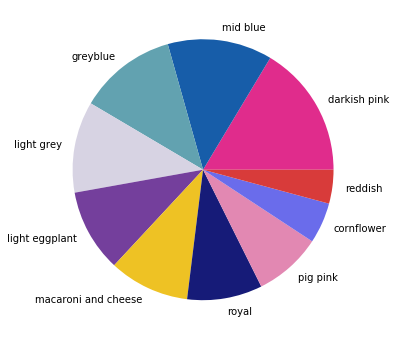

In [14]:
bounding_box = (20, 20, image.shape[0] - 20, image.shape[1] - 20) # define boundary box of the image
# Extracting contours.
contours = extract_contours(bounding_box)

# Extracting pixel values of of each contours.
px_vals = extract_contours_pxs(contours, False)
# print(px_vals.shape)

# Extracting name of the colors present in the contours
colors = extract_colors_kmean(num_clusters=10, px_values=px_vals, show_chart=False)

#### DBSCAN

In [11]:
from sklearn.cluster import OPTICS

In [16]:
def extract_colors_dbscan(num_clusters, px_values, show_chart=False):
    """
        This method is used to extract colors by using cluster algorithm K-means and labeled them.
    :param num_clusters: A integer tell how many cluster is needed.
    :param px_values: A numpy array contain the pixel values which will be clustered into num_clusters.
    :param show_chart: Displaying all the cluster with pie chart if True.

    :return : A list contains the name of the colors.
    """

    # Apply K-means clustering
    print('Number of cluster is :',num_clusters)
    dbscan = DBSCAN(eps=0.05, min_samples=10)
    clf = dbscan.fit(px_values/255)
    labels = clf.labels_ # get the center of the clusters
    print(f'center colors: {len(set(labels))}')
#     return None
    counts = Counter(labels)

    # We get ordered colors by iterating through the keys
    c = dict(counts)
    c = sorted(c.items(), key=lambda x: x[1], reverse=True)
    c = {k:v for k,v in c}
    counts = c
    total_px_vals = 0
    for k,v in counts.items():
        total_px_vals += v
    percentage = [v/total_px_vals*100 for k, v in counts.items()]
    print('Percentage:',percentage)
    
    center_colors = []
    for label in counts.keys():
        center_colors.append( px_values[np.where(labels==label)].mean(axis=0) )
    
    
    ordered_colors = [center_colors[i] for i in counts.keys()]
    hex_colors = [rgb2hex(i) for i in ordered_colors]
    rgb_colors = [i for i in ordered_colors]

    # Labeling the cluster
    color_names = get_labels(rgb_colors, color_codes).flatten()
    # print(color_names)

    # Display the cluster with pie chart.
#     if show_chart:
#         fig = plt.figure()

#         ax1 = fig.add_subplot(1, 2, 1)
#         ax1.imshow(resultant_image)
#         ax2 = fig.add_subplot(1, 2, 2)
#         plt.pie(counts.values(), labels=color_names, colors=hex_colors)
# #         plt.savefig(f'{settings.MEDIA_ROOT}/resultant_image.png', bbox_inches='tight', pad_inches=0)

    plt.figure(figsize=(8, 6))
    plt.pie(counts.values(), labels=color_names, colors=hex_colors)
#     plt.savefig('./tested_images/test_color_'+str(ii)+'b.png')
    plt.show()

    return color_names, percentage

Number of cluster is : 10
center colors: 42
Percentage: [79.21107506950881, 8.300509731232623, 3.805607043558851, 1.940454124189064, 1.3727988878591288, 0.9036144578313252, 0.3649212233549583, 0.24328081556997222, 0.2259036144578313, 0.20852641334569047, 0.17377201112140872, 0.17377201112140872, 0.15639481000926783, 0.15639481000926783, 0.15639481000926783, 0.15639481000926783, 0.13901760889712697, 0.13901760889712697, 0.13901760889712697, 0.12164040778498611, 0.12164040778498611, 0.12164040778498611, 0.10426320667284524, 0.10426320667284524, 0.10426320667284524, 0.10426320667284524, 0.10426320667284524, 0.08688600556070436, 0.08688600556070436, 0.08688600556070436, 0.08688600556070436, 0.08688600556070436, 0.08688600556070436, 0.06950880444856349, 0.06950880444856349, 0.06950880444856349, 0.06950880444856349, 0.06950880444856349, 0.06950880444856349, 0.06950880444856349, 0.06950880444856349, 0.06950880444856349]


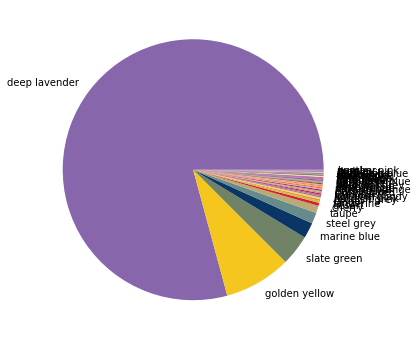

In [17]:
bounding_box = (20, 20, image.shape[0] - 20, image.shape[1] - 20) # define boundary box of the image
# Extracting contours.
contours = extract_contours(bounding_box)

# Extracting pixel values of of each contours.
px_vals = extract_contours_pxs(contours, False)
# print(px_vals.shape)

# Extracting name of the colors present in the contours
colors = extract_colors_dbscan(num_clusters=10, px_values=px_vals, show_chart=False)